In [112]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from analysis.pose import DLCArenaPose
from analysis.pose_utils import colorline, remove_outliers, zscore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
ap = ArenaPose('front', 'deeplabcut')

In [3]:
exp_dir = '../output/experiments/PV80'
videos = list(Path(exp_dir).rglob('*.mp4')) + list(Path(exp_dir).rglob('*.avi'))
videos = [v for v in videos if 'front' in v.name and ap.get_predicted_cache_path(v).exists()]
videos = sorted(videos, key=lambda x: x.stem.split('_')[1])
# videos

In [4]:
video_path = videos[-1]
pred_df = ap.load_predicted_video(video_path)

In [24]:
video_path

PosixPath('../output/experiments/PV80/20230221/block13/videos/front_20230221T181523.mp4')

In [90]:
video_path = Path('/data/Pogona_Pursuit/output/experiments/PV80/20230221/block13/videos/front_20230221T181523.mp4')
ap = DLCArenaPose('front', is_commit_db=False)
pred_df = ap.load_predicted(video_path)
pred_df

2023-02-25 00:09:39 - calibration-pose-estimator - INFO - MainProcess - Loaded 186 markers from ../output/calibrations/markers_front_null.pkl


left_ear                              nose                        \
            cam_x       cam_y      prob       cam_x       cam_y      prob   
0      754.301453   -0.151189  0.000126  762.878540   -5.285370  0.000248   
1      754.205872   -0.077392  0.000118  762.751343   -5.292593  0.000229   
2      754.097229   -0.162373  0.000123  762.748413   -5.305212  0.000239   
3      754.245789   -0.232433  0.000111  762.747559   -5.406330  0.000225   
4      754.048828   -0.082616  0.000123  762.763611   -5.333169  0.000237   
...           ...         ...       ...         ...         ...       ...   
15947  852.345825  774.577942  0.997236  865.511047  865.838440  0.989070   
15948  852.171997  774.674500  0.997213  865.580444  865.856079  0.989635   
15949  852.287354  774.537964  0.997325  865.593262  865.672241  0.989573   
15950  852.335693  774.713745  0.997149  865.695984  865.767639  0.989965   
15951  852.356384  774.647400  0.997211  865.715881  865.658142  0.989569   

        right_ear                                             time   left_ear  \
            cam_x       cam_y      prob                                     x   
0      760.184448   -0.076023  0.000167 2023-02-21 18:15:23.467934  18.103197   
1      760.135498   -0.119037  0.000156 2023-02-21 18:15:23.484599  18.119028   
2      760.140137   -0.122532  0.000165 2023-02-21 18:15:23.501264  18.154997   
3      760.176392   -0.216072  0.000157 2023-02-21 18:15:23.517928  18.102013   
4      760.036499   -0.064612  0.000165 2023-02-21 18:15:23.534593  18.161525   
...           ...         ...       ...                        ...        ...   
15947  789.940002  808.662842  0.997803 2023-02-21 18:19:49.220340  13.158098   
15948  790.197632  808.706055  0.997745 2023-02-21 18:19:49.237005  13.188246   
15949  790.161804  808.402161  0.997757 2023-02-21 18:19:49.253670  13.164406   
15950  790.244202  808.608826  0.997777 2023-02-21 18:19:49.270334  13.158944   
15951  790.250854  808.520874  0.997805 2023-02-21 18:19:49.286999  13.158311   

                       nose                          right_ear             \
               y          x          y is_in_screen          x          y   
0      79.981331  16.682617  81.682029         -1.0  17.128826  79.956433   
1      79.956886  16.703684  81.684421         -1.0  17.136933  79.970681   
2      80.013158  16.704654  81.692777         -1.0  17.135397  79.972995   
3      80.033093  16.704565  81.745814         -1.0  17.125900  80.023861   
4      79.936920  16.700091  81.691615         -1.0  17.166217  79.929190   
...          ...        ...        ...          ...        ...        ...   
15947   8.865371  12.172174   4.096511         -1.0  17.749795   7.268050   
15948   8.844760  12.157950   4.092617         -1.0  17.697478   7.271214   
15949   8.869222  12.157275   4.122030         -1.0  17.709561   7.324774   
15950   8.835694  12.142009   4.100099         -1.0  17.696997   7.282768   
15951   8.851719  12.143075   4.118451         -1.0  17.699469   7.300872   

          angle  
                 
0      4.213514  
1      4.219440  
2      4.206971  
3      4.225393  
4      4.211043  
...         ...  
15947  2.261548  
15948  2.262616  
15949  2.260650  
15950  2.263547  
15951  2.263684  

[15952 rows x 18 columns]

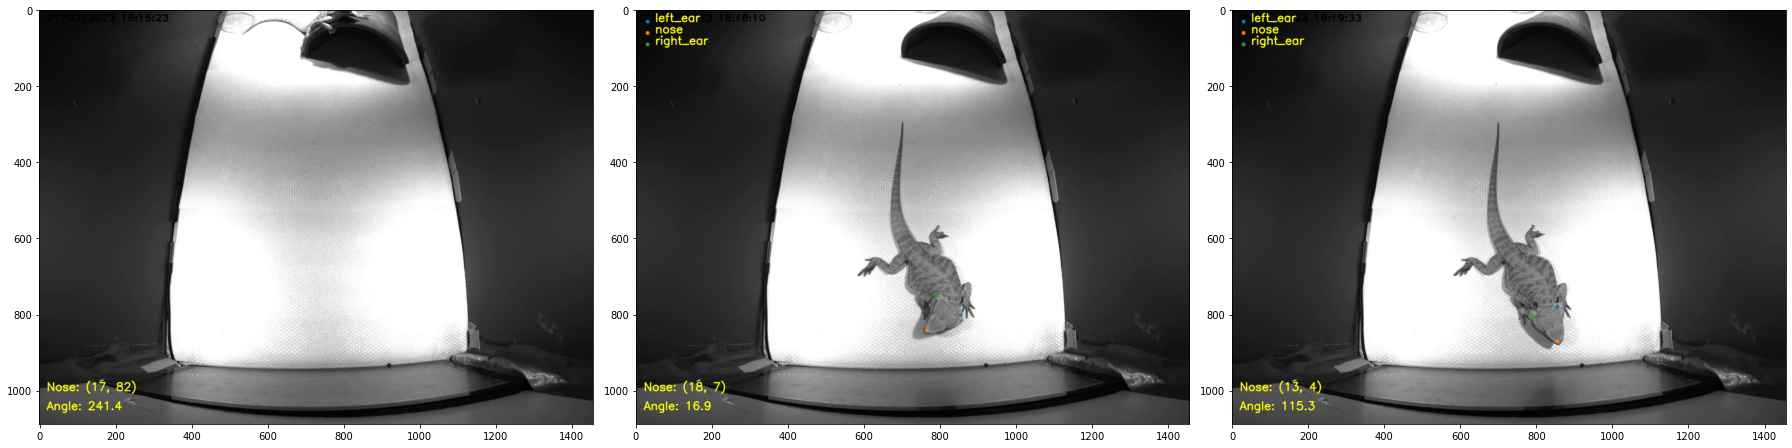

In [92]:
import math
from Arena.analysis.predictors.deeplabcut import PredPlotter

cap = cv2.VideoCapture(video_path.resolve().as_posix())
frames2plot = [0, 10000, 15000]
fig, axes = plt.subplots(1, len(frames2plot), figsize=(25, 10))
for i, frame_id in enumerate(frames2plot):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()
    frame = PredPlotter.plot_predictions(frame, frame_id, pred_df)
    angle = math.degrees(pred_df.loc[frame_id, ("angle")])
    x, y = pred_df.loc[frame_id, ("nose", ['x', 'y'])]
    frame = PredPlotter.put_text(f'Nose: {(round(x), round(y))}', frame, 20, 1000)
    frame = PredPlotter.put_text(f'Angle: {angle:.1f}', frame, 20, 1050)
    axes[i].imshow(frame)
fig.tight_layout()

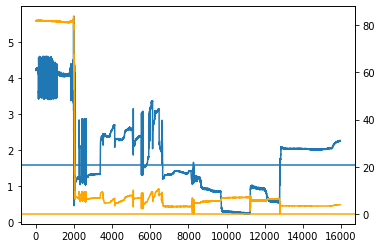

In [94]:
ax1 = plt.subplot()
pred_df['angle'].plot(ax=ax1)
ax1.axhline(np.pi/2)
ax2 = plt.twinx()
pred_df[('nose', 'y')].plot(ax=ax2, color='orange')
ax2.axhline(0, color='orange')

<AxesSubplot:xlabel='x', ylabel='y'>

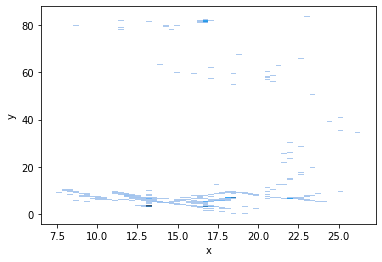

In [52]:
sns.histplot(data=pred_df['nose'], x='x', y='y')

In [149]:
type(pred_df['nose']) is pd.DataFrame

True

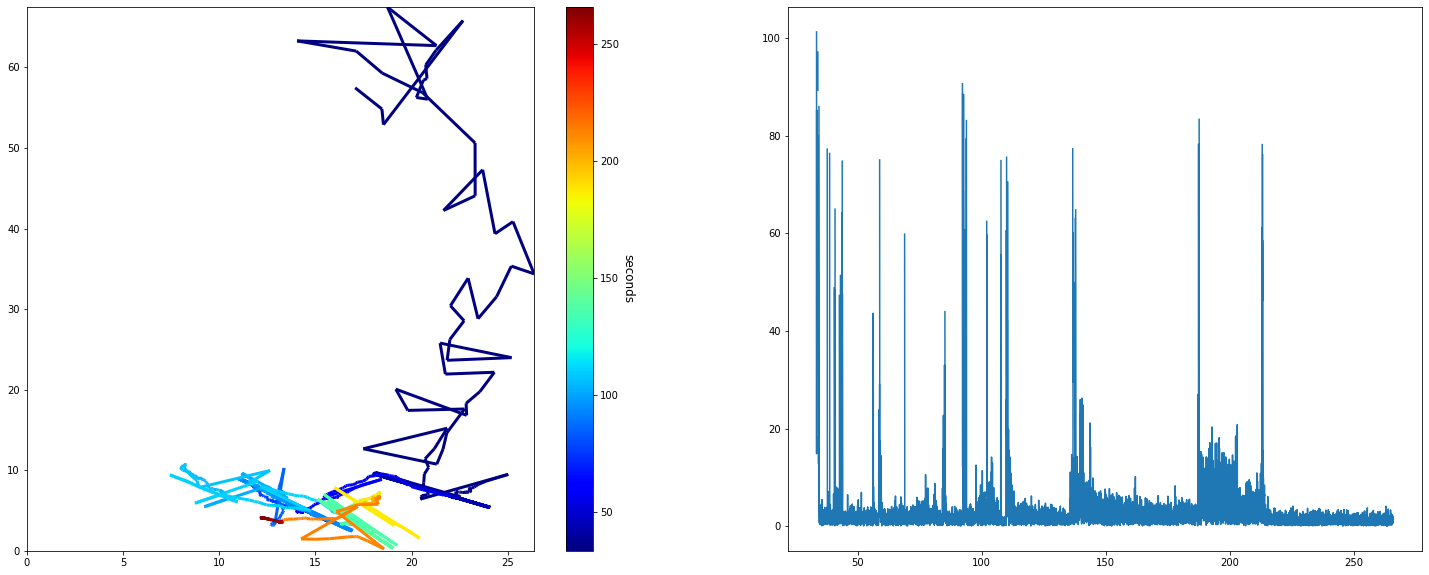

In [128]:
fig, axes = plt.subplots(1,2, figsize=(25, 10))
df = pred_df.nose.query('prob>0.7')
t = (pred_df.loc[df.index, 'time'] - pred_df['time'].iloc[0]).dt.total_seconds()
lc = colorline(axes[0], df.x, df.y, z=t, norm=None)
cbar = fig.colorbar(lc, ax=axes[0])
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('seconds', rotation=270, fontsize=12)

v = np.sqrt(df.x.diff()**2 + df.y.diff()**2)
v = remove_outliers(v.fillna(0), thresh=3, is_replace_nan=True)
v = v / t.diff()
axes[1].plot(t, v)

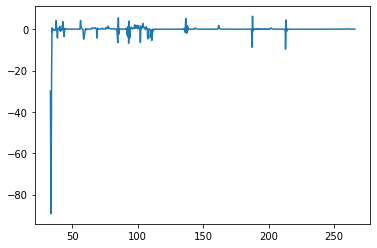

In [140]:
from scipy.signal import savgol_filter

def calc_derivative(x, y=None, dt=0.016, window_length=41, deriv=0):
    dx = savgol_filter(x, window_length=window_length, polyorder=2, deriv=deriv, delta=dt)
    if y is not None:
        dy = savgol_filter(y, window_length=window_length, polyorder=2, deriv=deriv, delta=dt)
        return np.insert(dx, 0, np.nan), np.insert(dy, 0, np.nan)
    else:
        return np.insert(dx, 0, np.nan)


# v = np.sqrt((np.vstack(calc_derivative(df.x, df.y, deriv=1)) ** 2).sum(axis=0))
v = calc_derivative(df.y, deriv=1)
plt.plot(t, v[1:])

2001     0.000000
2002          NaN
2003          NaN
2004          NaN
2005          NaN
           ...   
15947    0.158652
15948    0.071604
15949    0.184284
15950    0.140188
15951    0.111290
Length: 13951, dtype: float32

In [125]:
v

2001           NaN
2002     11.369472
2003      7.777082
2004      8.161995
2005      4.354556
           ...    
15947     0.158652
15948     0.071604
15949     0.184284
15950     0.140188
15951     0.111290
Length: 13951, dtype: float32

In [21]:
%matplotlib inline
from IPython.display import display, Image, clear_output
import ipywidgets

cap = cv2.VideoCapture(video_path.resolve().as_posix())
display_handle=display(None, display_id=True)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
image_widget = ipywidgets.Image(format='jpeg')
try:
    for i in range(n_frames):
        clear_output(wait=True)
        ret, frame = cap.read()
        frame = cv2.resize(frame, None, fx=0.25, fy=0.25)
        # _, frame = cv2.imencode('.jpeg', frame)
        image_widget.value =cv2.imencode('.jpeg', frame)[1].tobytes()
        # display_handle.update(Image(data=frame.tobytes()))
        display(image_widget)
except KeyboardInterrupt:
    pass
finally:
    cap.release()
    display_handle.update(None)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [17]:
video_path.resolve().as_posix()

'/data/Pogona_Pursuit/output/experiments/PV80/20230221/block13/videos/front_20230221T181523.mp4'

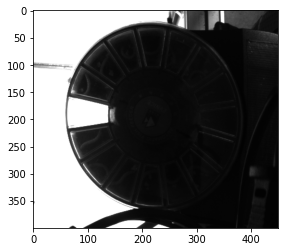

In [154]:
frame = cv2.imread('/data/Pogona_Pursuit/output/captures/20230225T145814_feeder.png')
x, y, w, h = (1000, 200, 450, 400)
plt.imshow(frame[y:y+h, x:x+w])

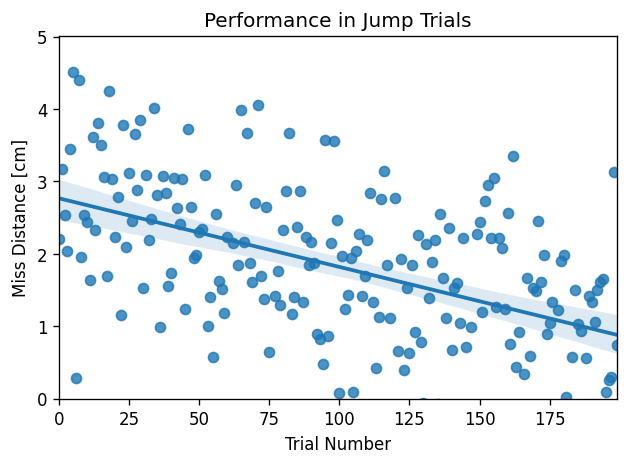

In [172]:
t = np.arange(200)
miss = 3*np.exp(-t/200) + np.random.normal(0,1,len(t))
plt.figure(dpi=120)
sns.regplot(x=t, y=miss)
plt.ylim([0, max(miss) + 0.5])
plt.ylabel('Miss Distance [cm]')
plt.xlabel('Trial Number')
plt.title('Performance in Jump Trials')
plt.show()

In [173]:
import pickle

with open('../output/jump_performance.pkl', 'wb') as f:
    pickle.dump({'miss': miss, 't': t}, f)